In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy.special import gammainc
from scipy.special import gamma
import mpmath
import scipy as sp


hfont = {'fontname':'Times New roman'}

In [19]:
lstar_ratio = np.array(range(0,3000))/1000 + 0.001
colorchoice = ['r', 'c', 'g', 'k']

light = 299792.458
H0 = 67.8#/3.08567758e24 ; centimeters  
little_h = H0/100.0
om = 0.308
dh = light/H0 # it's in Mpc



In [20]:
# Nielsen2013B, Table 3 values, b-band 
b_wcut        = np.array([0.1, 0.3, 0.6, 1.0])

b_rstar       = np.array([80, 79, 75, 74])/1000
b_rstar_plus  = np.array([130, 131, 111, 100])/1000
b_rstar_minus = np.array([72, 69, 70, 71])/1000

b_beta       = np.array([0.30, 0.38, 0.39, 0.38])
b_beta_plus  = np.array([0.33, 0.39, 0.40, 0.39])
b_beta_minus = np.array([0.29, 0.32, 0.35, 0.31])

b_frl       = np.array([0.85, 0.81, 0.59, 0.34])
b_frl_plus  = np.array([0.88, 0.85, 0.64, 0.39])
b_frl_minus = np.array([0.81, 0.79, 0.55, 0.30])


In [21]:
# calculate cross-section of strong absorbers
b = 3
halo_radius = b_rstar[b]*lstar_ratio**b_beta[b]
halo_radius_plus = b_rstar_plus[b]*lstar_ratio**b_beta_plus[b]
halo_radius_minus = b_rstar_minus[b]*lstar_ratio**b_beta_minus[b]

halo_crossection = b_frl[b]*halo_radius**2
halo_crossection_plus  = b_frl[b]*halo_radius_plus**2
halo_crossection_minus = b_frl[b]*halo_radius_minus**2

# number density
# for redshift <z> ~ 5
# mason2015b
mstar   = -21.2
mplus   = -21.0
mminus  = -21.4

phistar   = pow(10, -3.12) 
phiplus   = pow(10, -2.88) 
phiminus  = pow(10, -3.27) 

alpha=-1.75
alphaplus = alpha + 0.13
alphaminus = alpha - 0.13


N       = np.zeros(len(lstar_ratio)) 
N_minus = np.zeros(len(lstar_ratio)) 
N_plus  = np.zeros(len(lstar_ratio)) 


for l in range(0, len(lstar_ratio)):
    N[l]        =  phistar*float(mpmath.gammainc(alpha       + 1, lstar_ratio[l]))
    N_plus[l]   =  phiplus*float(mpmath.gammainc(alphaplus   + 1, lstar_ratio[l]))
    N_minus[l]  = phiminus*float(mpmath.gammainc(alphaminus  + 1, lstar_ratio[l]))


([<matplotlib.axis.YTick at 0x116334cf8>,
 <a list of 3 Text yticklabel objects>)

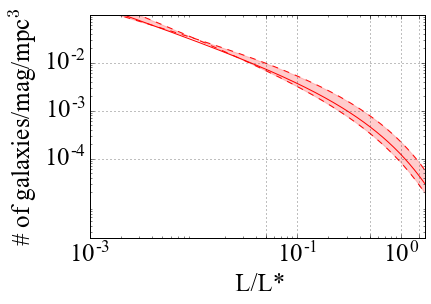

In [22]:
plt.plot(lstar_ratio, N, '-', color = colorchoice[0])
plt.plot(lstar_ratio, N_minus, '--', color = colorchoice[0], alpha=10)
plt.plot(lstar_ratio, N_plus, '--', color = colorchoice[0], alpha=10)


plt.fill_between(lstar_ratio, N_minus, N_plus, color = colorchoice[0], alpha = 0.2)


plt.yscale('log')
plt.xscale('log')



plt.grid(True)
plt.ylim([0, 0.1] )
plt.xlim([0.001, 1.7])
plt.ylabel('# of galaxies/mag/mpc$^3$', **hfont,  fontsize=25)
plt.xlabel(' L/L*', **hfont,  fontsize=25)


plt.xticks([0.001, 0.05, 0.1, 0.5, 1.0, 1.5], **hfont, fontsize = 25)

plt.yticks([pow(10, -4), pow(10, -3), pow(10, -2)], **hfont, fontsize = 25)




In [23]:
# define E(z) function
def get_ez(om, redshift):
    ol = 1.0 - om
    a = om*(1.0 + redshift)**3
    ez = (a + ol)**0.5
    return(ez)
    
# get the comoving distance between two redshift points    
def get_comoving_distance(om, H0, zmin, zmax):
    light = 299792.458 # it's in km/s
    dh = light/H0 # it's in Mpc/h

    step_size = 0.0001
    num_steps = (zmax-zmin)/step_size
    redshift_array = zmin + np.array(range(0, int(num_steps) + 1))*0.0001
    temp_dc = 0.0
    for n in range(0, int(num_steps)):
        local_ez = get_ez(om, redshift_array[n])
        temp_dc = temp_dc + 1./local_ez*step_size

    dc = temp_dc*dh
    print('the comoving distance between', zmin, ' and ', zmax, ' is', dc , ' comoving Mpc/h')
    return(dc)

# get the angular diameter distance between two redshift points    
def get_angular_diameter_distance(om, H0, zmax):
    light = 299792.458 # it's in km/s
    dh = light/H0 # it's in Mpc/h
    dc = get_comoving_distance(om, H0, 0, zmax)
    da = dc/(1.0 + zmax)
    return(da)

# get delta_z from a velocity offset
def get_dz_from_dv(redshift, dv):
    # dv/c = dz/(1.+z)
    light = 299792.458 # in kms^-1
    dz = dv/light*(1. + redshift)
    return(dz)


# probability of intersecting 1 object
def get_probability_of_intersection(n, cross_section, dh, redshift):
    dpoverdz = n*cross_section*dh*(1+redshift)**2/get_ez(om, redshift)
    return(dpoverdz)

In [38]:
# get redshift boundary from dv = [-100, 1600]
redshift = 4.85878
dz1 = get_dz_from_dv(redshift, 100)
dz2 = get_dz_from_dv(redshift, 1600)
comoving_dcz12 = get_comoving_distance(om, H0, redshift - dz1, redshift + dz2)
physical_dcz12 = comoving_dcz12*little_h/(1. + redshift)
little_h_comoving_dcz12 = comoving_dcz12*little_h


print('physical distance between ', redshift - dz1 , 
      ' and ', redshift + dz2, ' is ', physical_dcz12, ' Mpc')
volume = 3.14*0.75*physical_dcz12**3
print()
print('the physical volume is ', volume, ' physical Mpc^3')

volume_density = 2/volume
print('the volume density is ', volume_density, ' per Mpc^3')

print()
comoving_volume = 3.14*0.75*comoving_dcz12**3
comoving_volume_density = 2/comoving_volume
print('the comoving physical volume is ', comoving_volume, ' comoving h^-1 Mpc^3')
print('the comoving volume density is ', comoving_volume_density, ' (comoving h^-1 Mpc^3)^-1')


print()
little_h_comoving_volume = 3.14*0.75*little_h_comoving_dcz12**3
little_h_comoving_volume_density = 2/little_h_comoving_volume
print('comoving*h distance between ', redshift - dz1 , 
      ' and ', redshift + dz2, ' is ', little_h_comoving_dcz12, ' Mpc')
print('the comoving physical volume is ', little_h_comoving_volume, ' comoving  h*Mpc^3')
print('the comoving volume density is ', little_h_comoving_volume_density, ' (comoving h*Mpc^3)^-1')



the comoving distance between 4.856825721350336  and  4.890048458394641  is 18.481170356  comoving Mpc/h
physical distance between  4.856825721350336  and  4.890048458394641  is  2.13871036314  Mpc

the physical volume is  23.0381092224  physical Mpc^3
the volume density is  0.0868126798383  per Mpc^3

the comoving physical volume is  14865.4931919  comoving h^-1 Mpc^3
the comoving volume density is  0.000134539767647  (comoving h^-1 Mpc^3)^-1

comoving*h distance between  4.856825721350336  and  4.890048458394641  is  12.5302335014  Mpc
the comoving physical volume is  4633.06511452  comoving  h*Mpc^3
the comoving volume density is  0.000431679665743  (comoving h*Mpc^3)^-1


In [25]:
l_index = 289 # corresponds to minimum lstar ration = 0.29
print('while we expect (from luminosity function)' , N[l_index], 
      ' +', N_plus[l_index]-N[l_index], 
      ' -', N[l_index] - N_minus[l_index])
print()


print('this means that we identify an overdensity of ', volume_density/N[l_index], 
      ' +', volume_density/N[l_index] - volume_density/N_plus[l_index], 
      ' -', volume_density/N_minus[l_index] - volume_density/N[l_index])

print('this means that we identify a comoving overdensity of ', comoving_volume_density/N[l_index], 
      ' +', comoving_volume_density/N[l_index] - comoving_volume_density/N_plus[l_index], 
      ' -', comoving_volume_density/N_minus[l_index] - comoving_volume_density/N[l_index])

print('this means that we identify a comoving*h overdensity of ', little_h_comoving_volume_density/N[l_index], 
      ' +', little_h_comoving_volume_density/N[l_index] - little_h_comoving_volume_density/N_plus[l_index], 
      ' -', little_h_comoving_volume_density/N_minus[l_index] - little_h_comoving_volume_density/N[l_index])


print()
print('when considering galaxies with L/L* = ', lstar_ratio[l_index])


while we expect (from luminosity function) 0.00105775293705  + 0.000636611001024  - 0.00024204153092

this means that we identify an overdensity of  82.0727381581  + 30.836591137  - 24.3529893555
this means that we identify a comoving overdensity of  0.127193943817  + 0.0477896525522  - 0.0377415549837
this means that we identify a comoving*h overdensity of  0.187601687045  + 0.0704862132038  - 0.0556660103004

when considering galaxies with L/L* =  0.29


In [26]:
l_index = 999 # corresponds to minimum lstar ration = 1.0
print('while we expect (from luminosity function)' , N[l_index], 
      ' +', N_plus[l_index]-N[l_index], 
      ' -', N[l_index] - N_minus[l_index])
print()


print('this means that we identify an overdensity of ', volume_density/N[l_index], 
      ' +', volume_density/N[l_index] - volume_density/N_plus[l_index], 
      ' -', volume_density/N_minus[l_index] - volume_density/N[l_index])
print('this means that we identify a comoving overdensity of ', comoving_volume_density/N[l_index], 
      ' +', comoving_volume_density/N[l_index] - comoving_volume_density/N_plus[l_index], 
      ' -', comoving_volume_density/N_minus[l_index] - comoving_volume_density/N[l_index])
print('this means that we identify a comoving*h overdensity of ', little_h_comoving_volume_density/N[l_index], 
      ' +', little_h_comoving_volume_density/N[l_index] - little_h_comoving_volume_density/N_plus[l_index], 
      ' -', little_h_comoving_volume_density/N_minus[l_index] - little_h_comoving_volume_density/N[l_index])


print()
print('when considering galaxies with L/L* = ', lstar_ratio[l_index])


while we expect (from luminosity function) 0.000123014896285  + 0.00010129480153  - 3.98836829008e-05

this means that we identify an overdensity of  705.708678054  + 318.687159663  - 338.576329997
this means that we identify a comoving overdensity of  1.09368679493  + 0.493892096096  - 0.524715754121
this means that we identify a comoving*h overdensity of  1.61310736716  + 0.728454419021  - 0.773917041476

when considering galaxies with L/L* =  1.0


In [27]:
# now make a plot of volume density ratio as a function of luminosity ratio
volume_density_ratio = np.array(range(0, len(N)))
volume_density_ratio_low = np.array(range(0, len(N)))
volume_density_ratio_high = np.array(range(0, len(N)))


comoving_volume_density_ratio = np.array(range(0, len(N)))
comoving_volume_density_ratio_low = np.array(range(0, len(N)))
comoving_volume_density_ratio_high = np.array(range(0, len(N)))

little_h_comoving_volume_density_ratio = np.array(range(0, len(N)))
little_h_comoving_volume_density_ratio_low = np.array(range(0, len(N)))
little_h_comoving_volume_density_ratio_high = np.array(range(0, len(N)))




for l in range(0, len(volume_density_ratio)):
    l_index = l
     
    volume_density_ratio[l]      = volume_density/N[l_index]
    volume_density_ratio_high[l] = volume_density/N_minus[l_index]
    volume_density_ratio_low[l]  = volume_density/N_plus[l_index] 

    comoving_volume_density_ratio[l]      = comoving_volume_density/N[l_index]
    comoving_volume_density_ratio_high[l] = comoving_volume_density/N_minus[l_index] 
    comoving_volume_density_ratio_low[l]  = comoving_volume_density/N_plus[l_index] 

    little_h_comoving_volume_density_ratio[l]      = little_h_comoving_volume_density/N[l_index]
    little_h_comoving_volume_density_ratio_high[l] = little_h_comoving_volume_density/N_minus[l_index] 
    little_h_comoving_volume_density_ratio_low[l]  = little_h_comoving_volume_density/N_plus[l_index] 



    

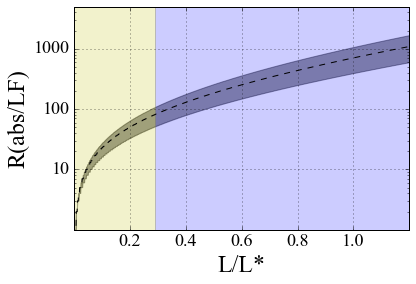

In [28]:
plt.yscale('log')
plt.xlim([0, 1.2])
plt.ylim([1, 5000])
plt.grid(True)
hfont = {'fontname':'Times New roman'}
# x and y ticks
xlabels = ['0.2', '0.4',  '0.6', '0.8', '1.0']
plt.xticks([0.2, 0.4, 0.6, 0.8, 1.0], 
            xlabels, **hfont, fontsize = 18)
ylabels = ['10', '100', '1000']
plt.yticks([10, 100, 1000], 
            ylabels, **hfont, fontsize = 18)

# x, y labels and title
plt.xlabel('L/L*', **hfont,  fontsize=24)
ylabel='R(abs/LF)'
plt.ylabel(ylabel, **hfont,  fontsize=24)
plt.title(' ', **hfont,  fontsize=24)


plt.plot(lstar_ratio, volume_density_ratio, 'k--', lw=1)
plt.fill_between(lstar_ratio, volume_density_ratio_low, volume_density_ratio_high, color = 'k', alpha = 0.4)

plt.fill_between([0.29, 2], [0., 0.], [10**6, 10**6], color = 'b', alpha = 0.2)
plt.fill_between([0., 0.29], [0., 0.], [10**6, 10**6], color = 'y', alpha = 0.2)



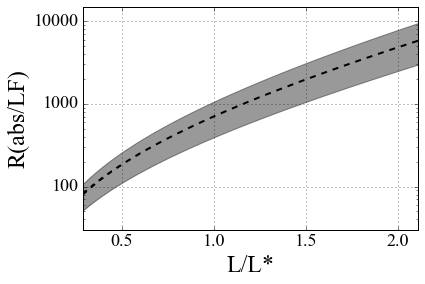

In [29]:
plt.yscale('log')
plt.xlim([0.29, 2.11])
plt.ylim([30, 15000])
plt.grid(True)
hfont = {'fontname':'Times New roman'}
# x and y ticks
xlabels = ['0.5', '1.0', '1.5', '2.0']
plt.xticks([0.5, 1.0, 1.5, 2.0], 
            xlabels, **hfont, fontsize = 18)
ylabels = [ '100', '1000', '10000']
plt.yticks([100, 1000, 10000], 
            ylabels, **hfont, fontsize = 18)

# x, y labels and title
plt.xlabel('L/L*', **hfont,  fontsize=24)
ylabel='R(abs/LF)'
plt.ylabel(ylabel, **hfont,  fontsize=24)
plt.title(' ', **hfont,  fontsize=24)


plt.plot(lstar_ratio, volume_density_ratio, 'k--', lw=2)
plt.fill_between(lstar_ratio, volume_density_ratio_low, volume_density_ratio_high, color = 'k', alpha = 0.4)
#plt.fill_between(lstar_ratio, volume_density_ratio_low, volume_density_ratio_high, color = 'b', alpha = 0.2)


# plt.fill_between([0.29, 2], [0., 0.], [10**6, 10**6], color = 'b', alpha = 0.2)
# plt.fill_between([0., 0.29], [0., 0.], [10**6, 10**6], color = 'y', alpha = 0.2)




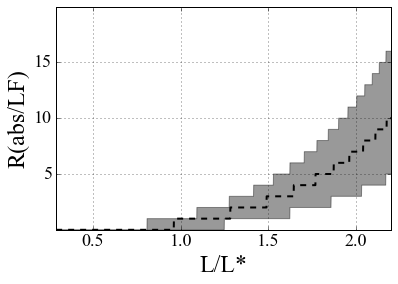

In [30]:
# if units of luminosity function are comoving
plt.xlim([0.29, 2.2])
plt.ylim([0, 17])
plt.grid(True)
hfont = {'fontname':'Times New roman'}
# x and y ticks
xlabels = ['0.5', '1.0', '1.5', '2.0']
plt.xticks([0.5, 1.0, 1.5, 2.0], 
            xlabels, **hfont, fontsize = 18)
ylabels = [ '5', '10', '15', ' ']
plt.yticks([ 5, 10, 15, 20], 
            ylabels, **hfont, fontsize = 18)

# x, y labels and title
plt.xlabel('L/L*', **hfont,  fontsize=24)
ylabel='R(abs/LF)'
plt.ylabel(ylabel, **hfont,  fontsize=24)
plt.title(' ', **hfont,  fontsize=24)


plt.plot(lstar_ratio, comoving_volume_density_ratio, 'k--', lw=2)
plt.fill_between(lstar_ratio, comoving_volume_density_ratio_low, 
                 comoving_volume_density_ratio_high, color = 'k', alpha = 0.4)
#plt.fill_between(lstar_ratio, comoving_volume_density_ratio_low, 
#                 comoving_volume_density_ratio_high, color = 'b', alpha = 0.2)

#plt.fill_between([0.29, 4], [0., 0.], [10**6, 10**6], color = 'b', alpha = 0.2)
#plt.fill_between([0., 0.29], [0., 0.], [10**6, 10**6], color = 'y', alpha = 0.2)


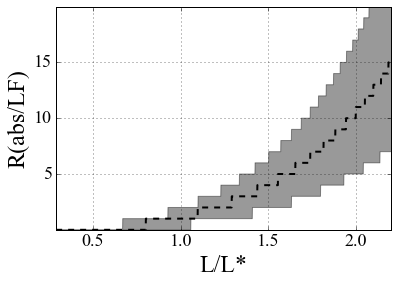

In [31]:
# if units of luminosity function are comoving*h
plt.xlim([0.29, 2.2])
plt.ylim([0, 17])
plt.grid(True)
hfont = {'fontname':'Times New roman'}
# x and y ticks
xlabels = ['0.5', '1.0', '1.5', '2.0']
plt.xticks([0.5, 1.0, 1.5, 2.0], 
            xlabels, **hfont, fontsize = 18)
ylabels = [ '5', '10', '15', ' ']
plt.yticks([ 5, 10, 15, 20], 
            ylabels, **hfont, fontsize = 18)

# x, y labels and title
plt.xlabel('L/L*', **hfont,  fontsize=24)
ylabel='R(abs/LF)'
plt.ylabel(ylabel, **hfont,  fontsize=24)
plt.title(' ', **hfont,  fontsize=24)


plt.plot(lstar_ratio, little_h_comoving_volume_density_ratio, 'k--', lw=2)
plt.fill_between(lstar_ratio, little_h_comoving_volume_density_ratio_low, 
                 little_h_comoving_volume_density_ratio_high, color = 'k', alpha = 0.4)
#plt.fill_between(lstar_ratio, comoving_volume_density_ratio_low, 
#                 comoving_volume_density_ratio_high, color = 'b', alpha = 0.2)

#plt.fill_between([0.29, 4], [0., 0.], [10**6, 10**6], color = 'b', alpha = 0.2)
#plt.fill_between([0., 0.29], [0., 0.], [10**6, 10**6], color = 'y', alpha = 0.2)



In [32]:
# check to see if I get Gonzalo's number
dz = get_dz_from_dv(5.7242, 1000)
dc5d7 = get_comoving_distance(om, H0, 5.7242, 5.7242 + dz)



the comoving distance between 5.7242  and  5.746629516889314  is 10.1726305445  comoving Mpc/h


In [33]:
# get the physical distance between two MgII components +/-150 at +750 from 4.856825721350336
redshift = 4.85878
z_center = redshift + get_dz_from_dv(redshift, 750)
z1 = z_center - get_dz_from_dv(z_center, 150)
z2 = z_center + get_dz_from_dv(z_center, 150)

comoving_dc_z12 = get_comoving_distance(om, H0, z1, z2)
physical_dc_z12 = comoving_dc_z12*little_h/(1.0 + z_center)

print('physical distance between ', z1, 
      ' and ', z2, ' is ', physical_dc_z12, ' physical Mpc')




the comoving distance between 4.870498338279608  and  4.876375841465368  is 3.22864537549  comoving Mpc/h
physical distance between  4.870498338279608  and  4.876375841465368  is  0.372698563225  physical Mpc


get

In [34]:
get_comoving_distance(om, H0, 4.61, 4.86)

the comoving distance between 4.61  and  4.86  is 144.216415805  comoving Mpc/h


144.21641580470913